## Entire domanin (extrapolation)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hython

import os
import xarray as xr
import random 
import numpy as np
from pathlib import Path 
import glob

from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

# Eurac utils
from hython.preprocess import preprocess, apply_normalization
from hython.models.lstm import CustomLSTM, CudnnLSTM
from hython.metrics import RMSELoss
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler
from hython.viz import plot_sampler
from hython.utils import missing_location_idx, reconstruct_from_missing

# visualize 
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs

import warnings
warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


In [3]:
## user settings

domain = "alps" # "alps"

timeslice = slice("2016-01-01","2020-12-31")


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc"] #  ,"actevap" ] # "q_river"]

In [4]:
if domain == "alps":
    ipath = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/full_domain/alps1km')
    dyn_vars_ds = xr.open_dataset(ipath / 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc', decode_coords='all',chunks= {"time":100})
    static_params_ds = xr.open_dataset(ipath / "staticmaps.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1)
    target_ds = xr.open_dataset(ipath / "run_default/output.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))
    target_ds.dims,dyn_vars_ds.dims, static_params_ds.dims
if domain == "adige":
    glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')
    dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
    static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
    target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))
    dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims
if domain == "demo":
    dyn_vars_ds = xr.open_dataset('../data/dyn_vars.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
    static_params_ds = xr.open_dataset('../data/staticmaps_calibrated_parameters.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
    target_ds = xr.open_dataset('../data/soil_moisture_2019.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))

    target_ds = target_ds.rename_vars({"vwc_percroot":"vwc"})
    dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims

In [5]:
if timeslice:
    dyn_vars_ds = dyn_vars_ds.sel(time=timeslice)
    target_ds = target_ds.sel(time=timeslice)
    target_ds.dims,dyn_vars_ds.dims

In [6]:
def get_domain(intervals, train_origin, valid_origin, file= ["Xd", "Xs", "Y"]):
    loaded = np.load(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}.npz',
                    allow_pickle=True)
    return loaded[file]

In [7]:
Xd = get_domain(intervals = (0, 0),
            train_origin = (0, 0),
            valid_origin =  (0, 0),
          file= "Xd" )

In [8]:
Xs = get_domain(intervals = (0, 0),
            train_origin = (0, 0),
            valid_origin =  (0, 0),
          file= "Xs" )

In [9]:
Y = get_domain(intervals = (0, 0),
            train_origin = (0, 0),
            valid_origin =  (0, 0),
          file= "Y" )

In [10]:
idx = missing_location_idx(Xs)

In [11]:
Xd_clean = Xd[~idx]
Xs_clean = Xs[~idx]
Y_clean = Y[~idx]

In [12]:
Xd_clean, d_m, d_std = apply_normalization(Xd_clean, type = "spacetime", how ='standard')
Xs_clean, s_m, s_std = apply_normalization(Xs_clean, type = "space", how ='standard')

In [13]:
how = "minmax"

In [14]:
Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how =how )

In [15]:
from hython.utils import predict, reconstruct_from_missing, reshape_to_2Dspatial, to_xr
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

In [16]:
spatial_batch_size =  256 # int(512 / 4)
temporal_sampling_size = 130
seq_length = 260

hidden_size = 256

In [17]:
model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": Y.shape[-1], # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
model.load_state_dict(torch.load("checkpoints/multi1-weights.pt"))

<All keys matched successfully>

In [20]:
yhat = predict(Xd_clean, Xs_clean, model, spatial_batch_size, device)

In [21]:
Y.shape

(810953, 1461, 2)

In [22]:
if how == "standard":
    yhat = (yhat*y_std) + y_m
if how == "minmax":
    yhat = yhat * (y_std - y_m) + y_m 

## SM

In [27]:
sm_idx = 0

In [28]:
yhat = reconstruct_from_missing(
                                yhat[...,sm_idx], 
                                Y[...,sm_idx].shape,
                                idx
    )
yhat.shape

(810953, 1461)

In [29]:
lat, lon, time = len(target_ds.lat), len(target_ds.lon), Y.shape[1]
lat*lon,time

(810953, 1461)

In [30]:
yhat = reshape_to_2Dspatial(
    yhat,
    lat,
    lon,
    time, 
    1)

In [31]:
y = reshape_to_2Dspatial(
    Y[...,sm_idx],
    lat,
    lon,
    time,
    1)

In [32]:
y = to_xr(y[...,0], coords = dict(target_ds.coords)).chunk({"lat":100,"lon":100})
yhat = to_xr(yhat[...,0], coords = dict(target_ds.coords)).chunk({"lat":100,"lon":100})

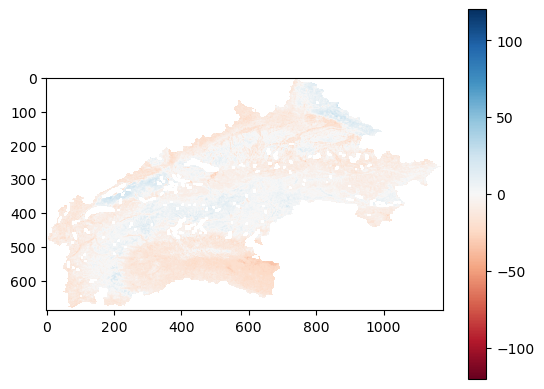

In [33]:
map_pbias(y, yhat)

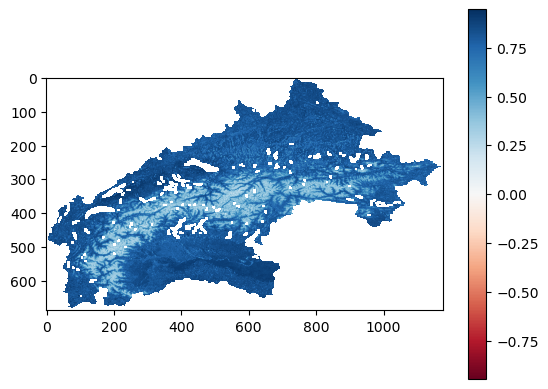

In [34]:
map_pearson(y, yhat)

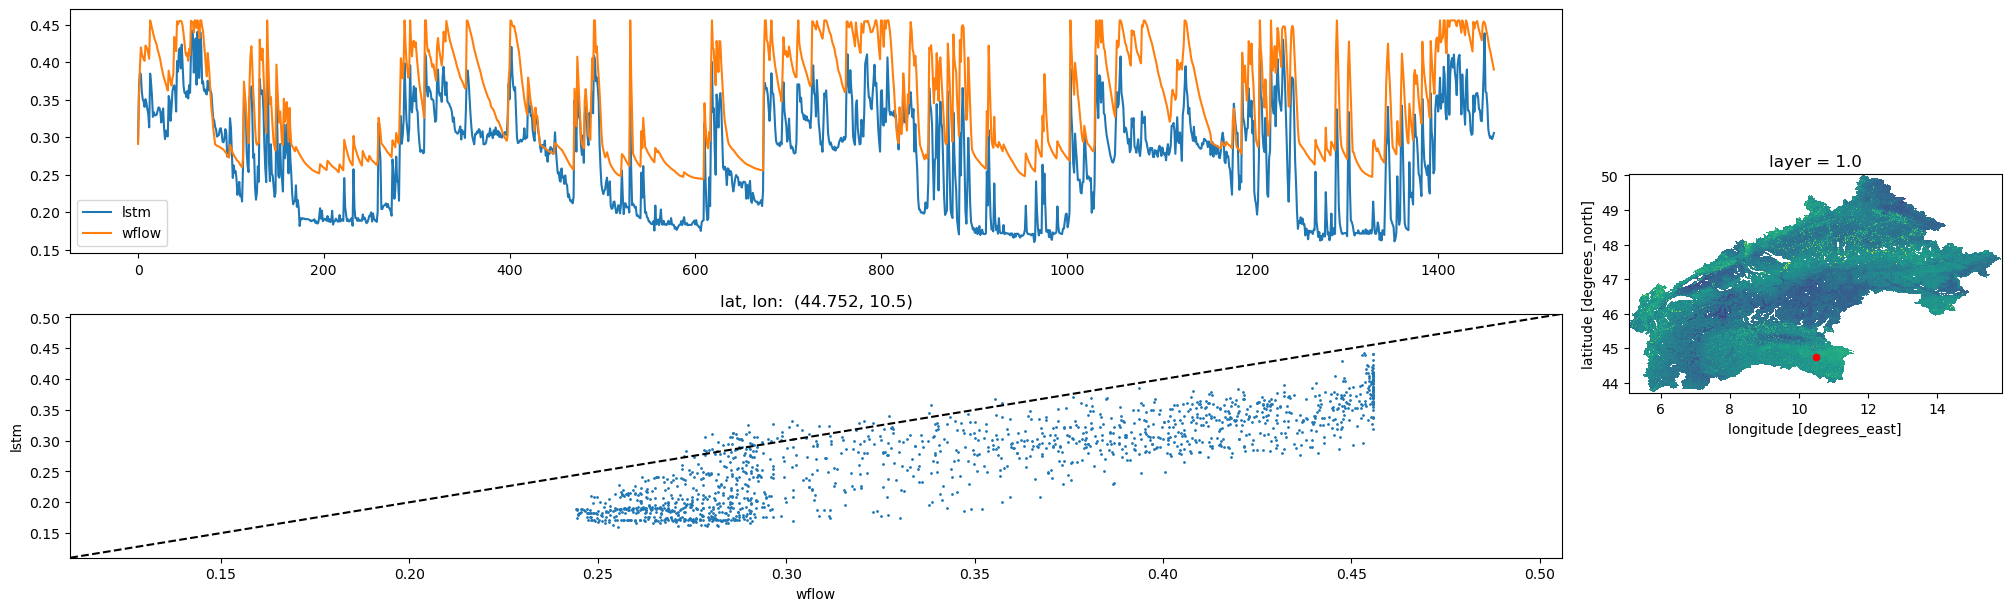

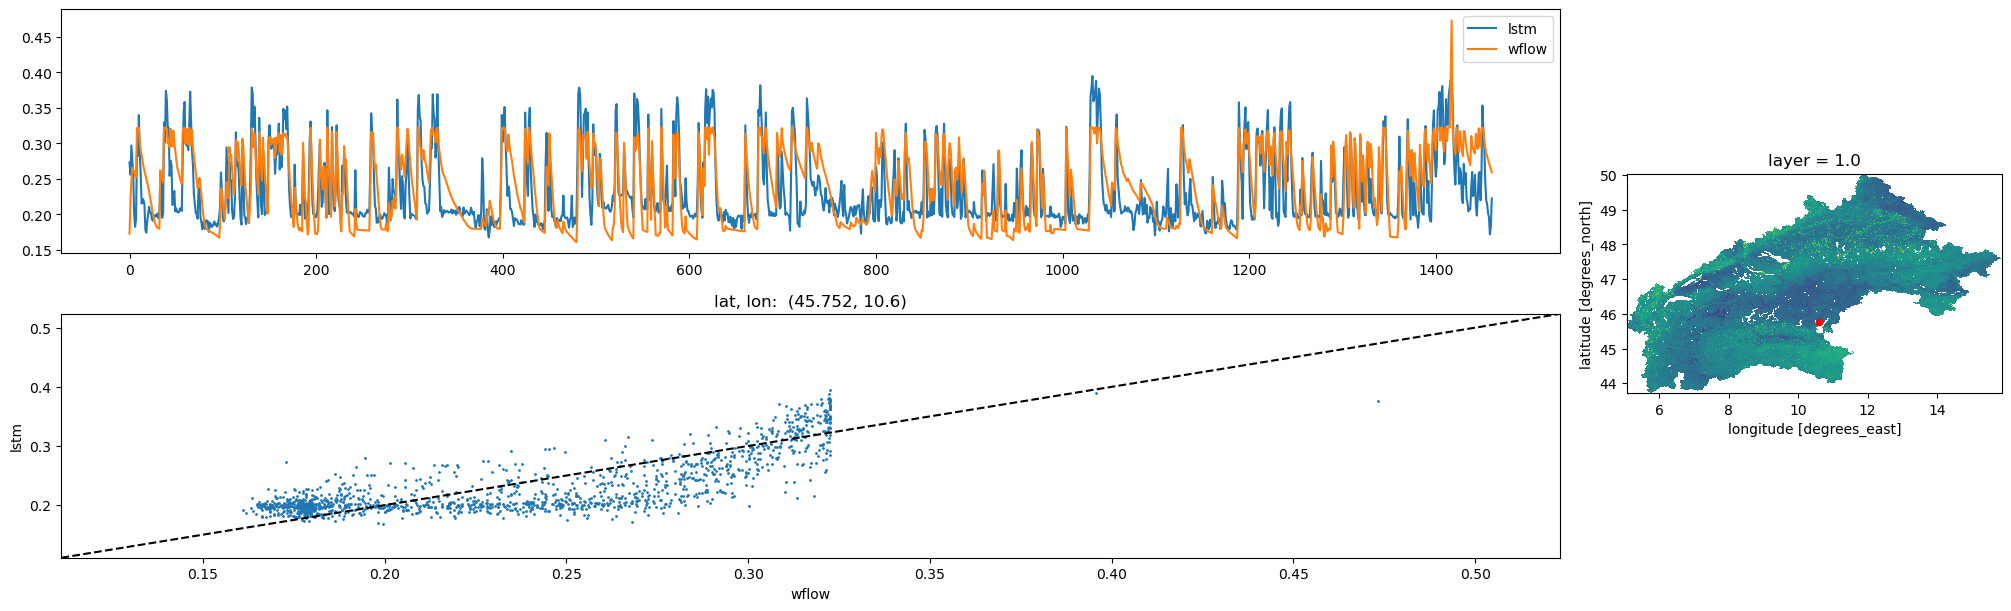

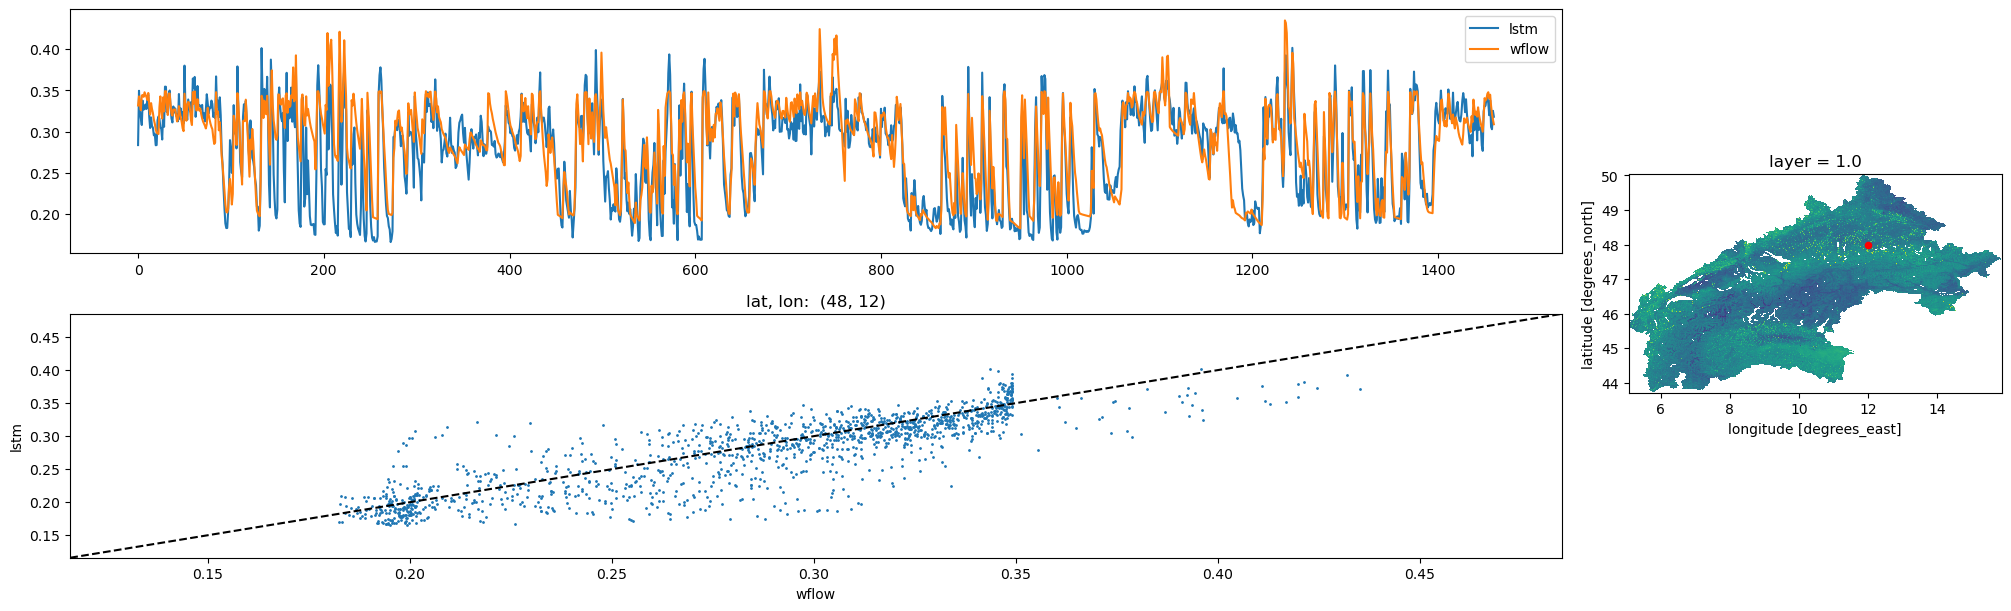

In [35]:
ts_compare(y, yhat, lat = [44.752, 45.752, 48], lon = [10.5,10.6, 12]) # pixel on river

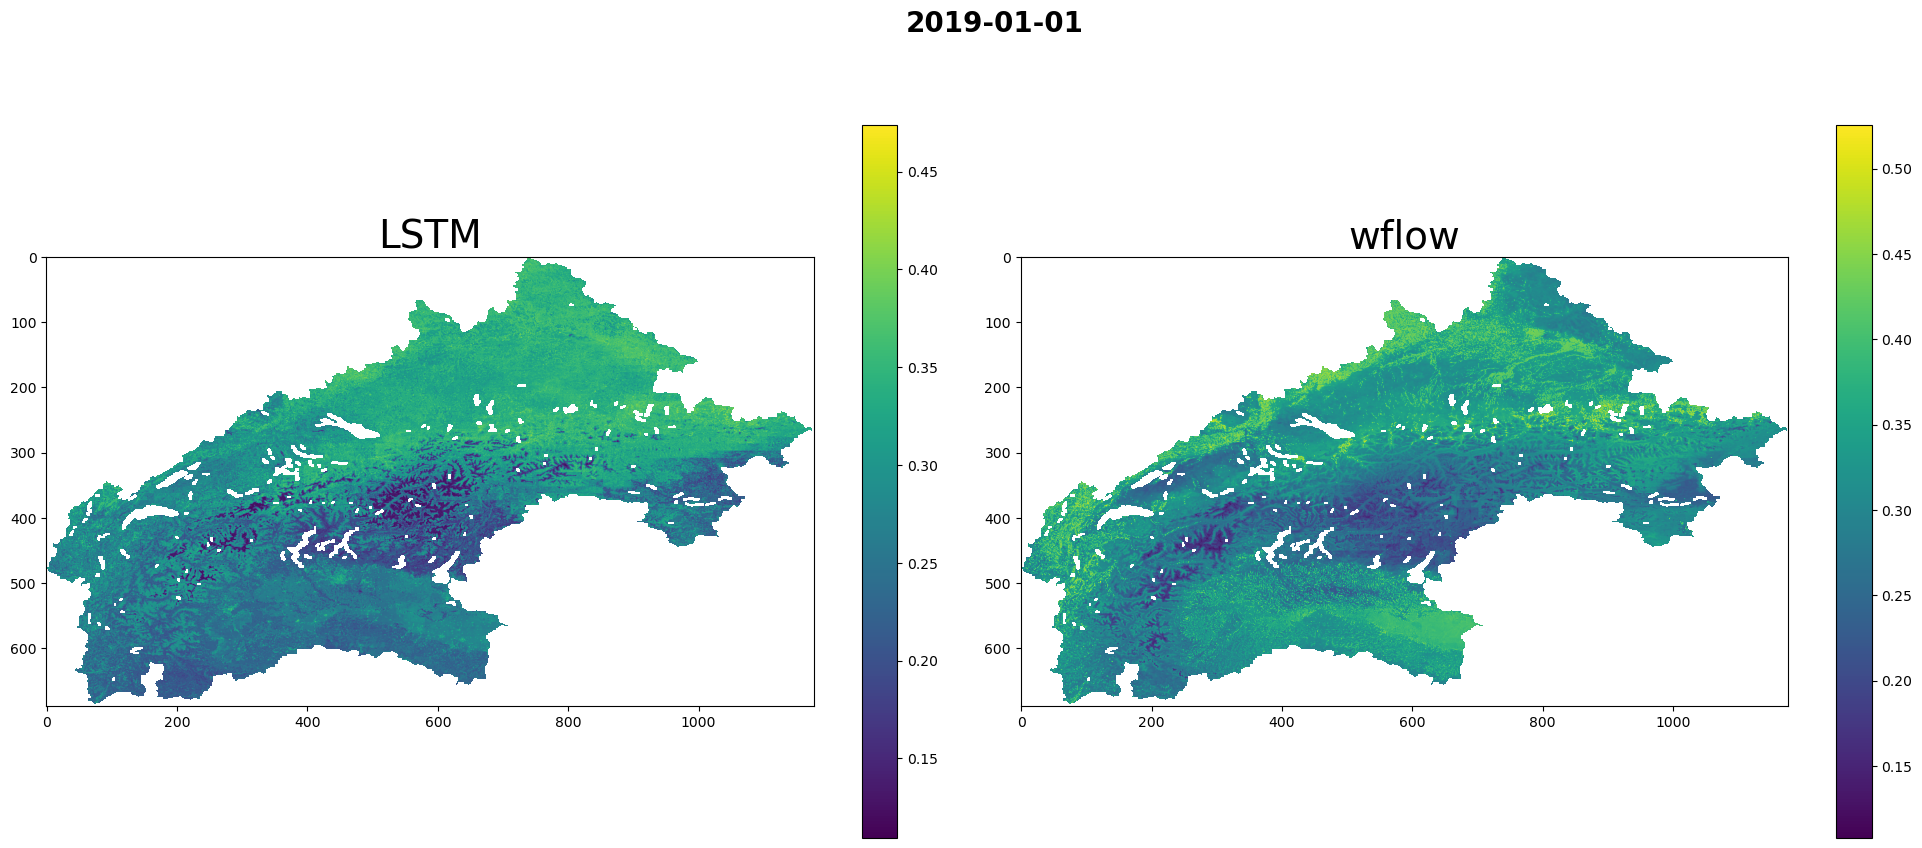

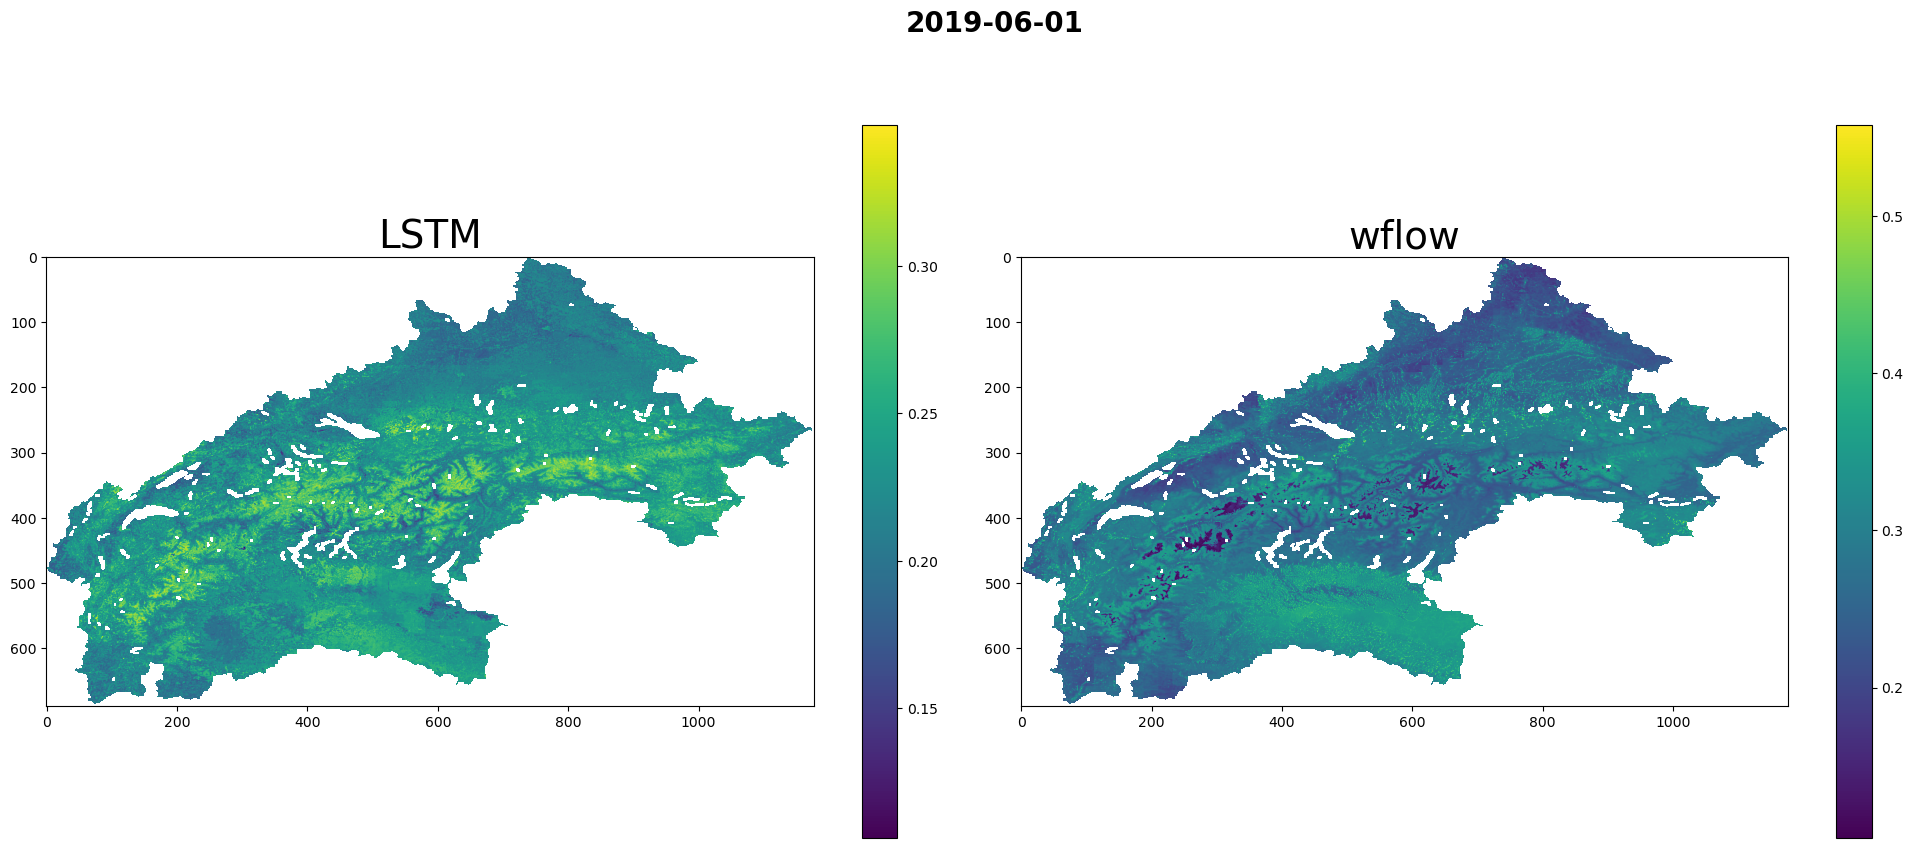

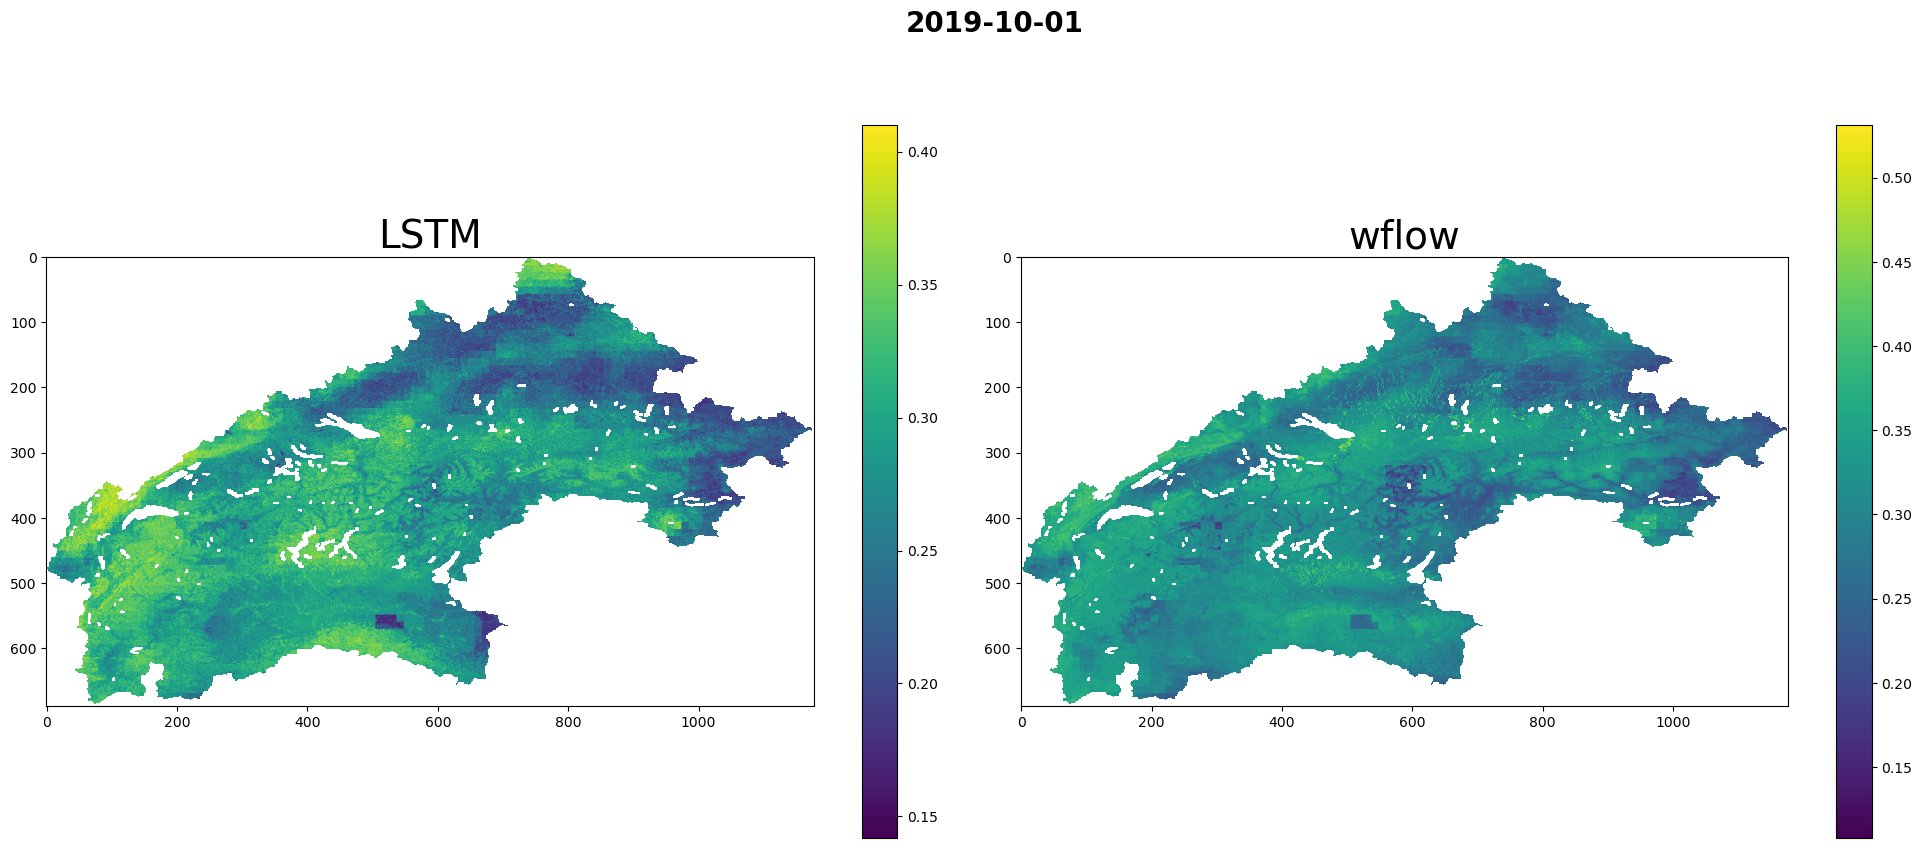

In [36]:
map_at_timesteps(y, yhat, dates=["2019-01-01", "2019-06-01","2019-10-01"])

## ET

In [23]:
et_idx = 1

In [24]:
yhat = reconstruct_from_missing(
                                yhat[...,et_idx], 
                                Y[...,et_idx].shape,
                                idx
    )
yhat.shape

(810953, 1461)

In [25]:
lat, lon, time = len(target_ds.lat), len(target_ds.lon), Y.shape[1]
lat*lon,time

(810953, 1461)

In [26]:
yhat = reshape_to_2Dspatial(
    yhat,
    lat,
    lon,
    time, 
    1)

In [28]:
y = reshape_to_2Dspatial(
    Y[...,et_idx],
    lat,
    lon,
    time,
    1)

In [29]:
y = to_xr(y[...,0], coords = dict(target_ds.coords)).chunk({"lat":100,"lon":100})
yhat = to_xr(yhat[...,0], coords = dict(target_ds.coords)).chunk({"lat":100,"lon":100})

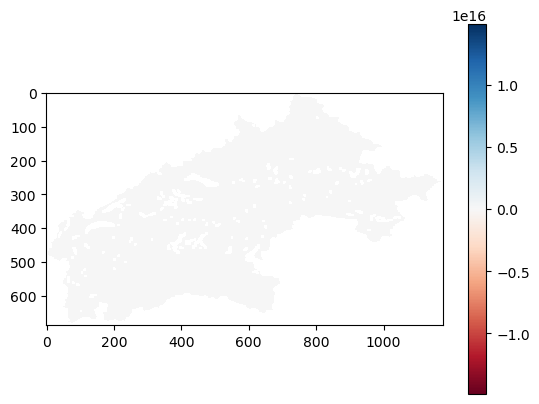

In [30]:
map_pbias(y, yhat)

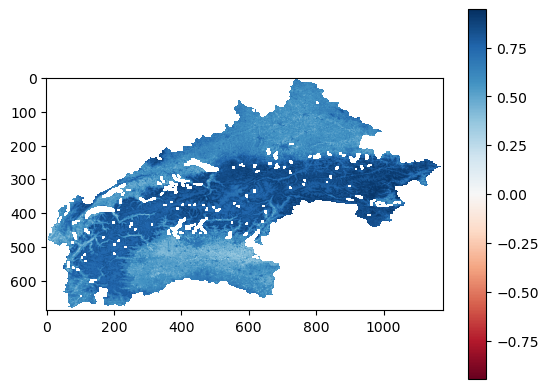

In [31]:
map_pearson(y, yhat)

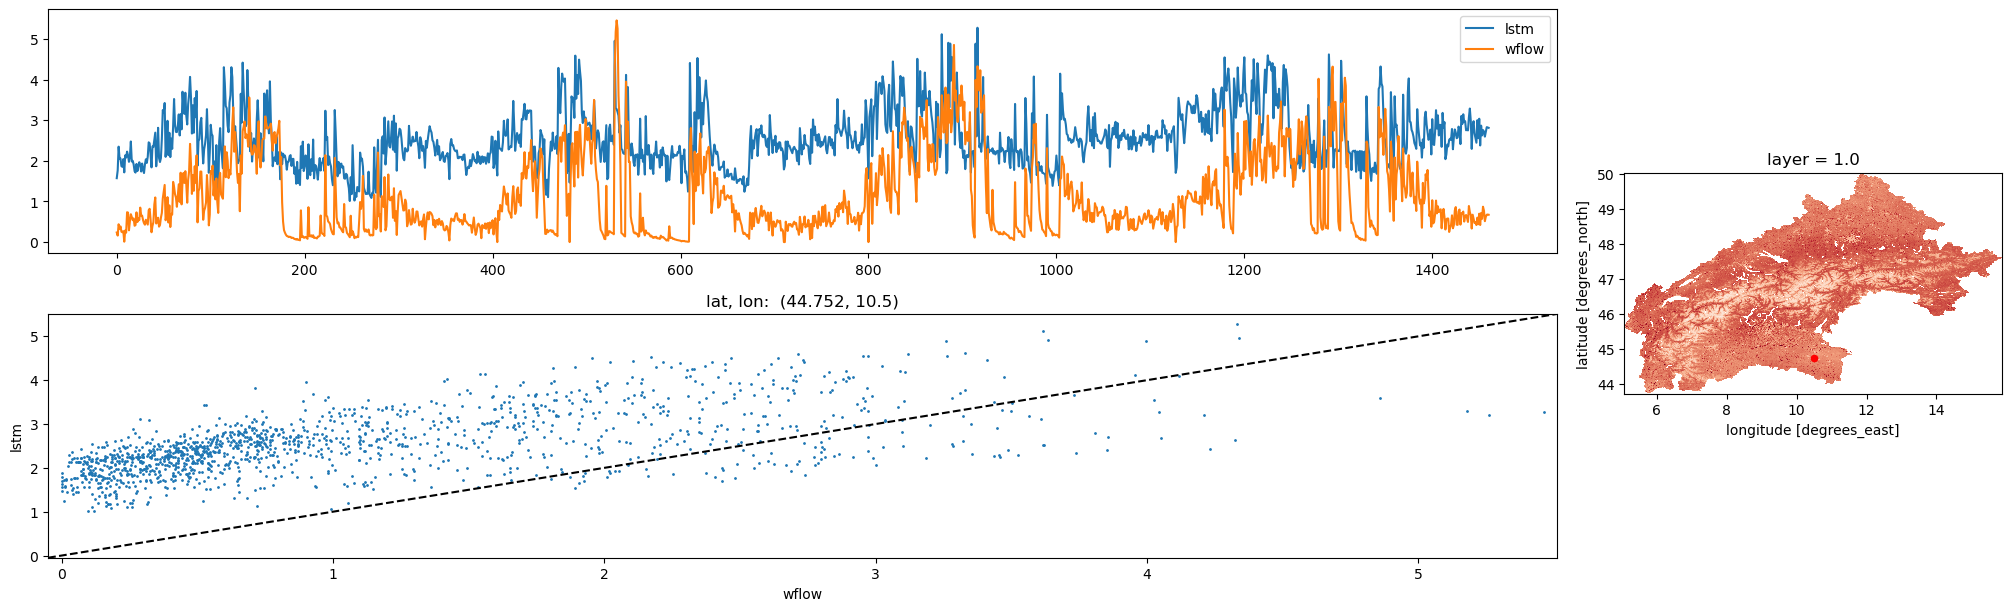

In [32]:
ts_compare(y, yhat, lat = [44.752], lon = [10.5]) # pixel on river

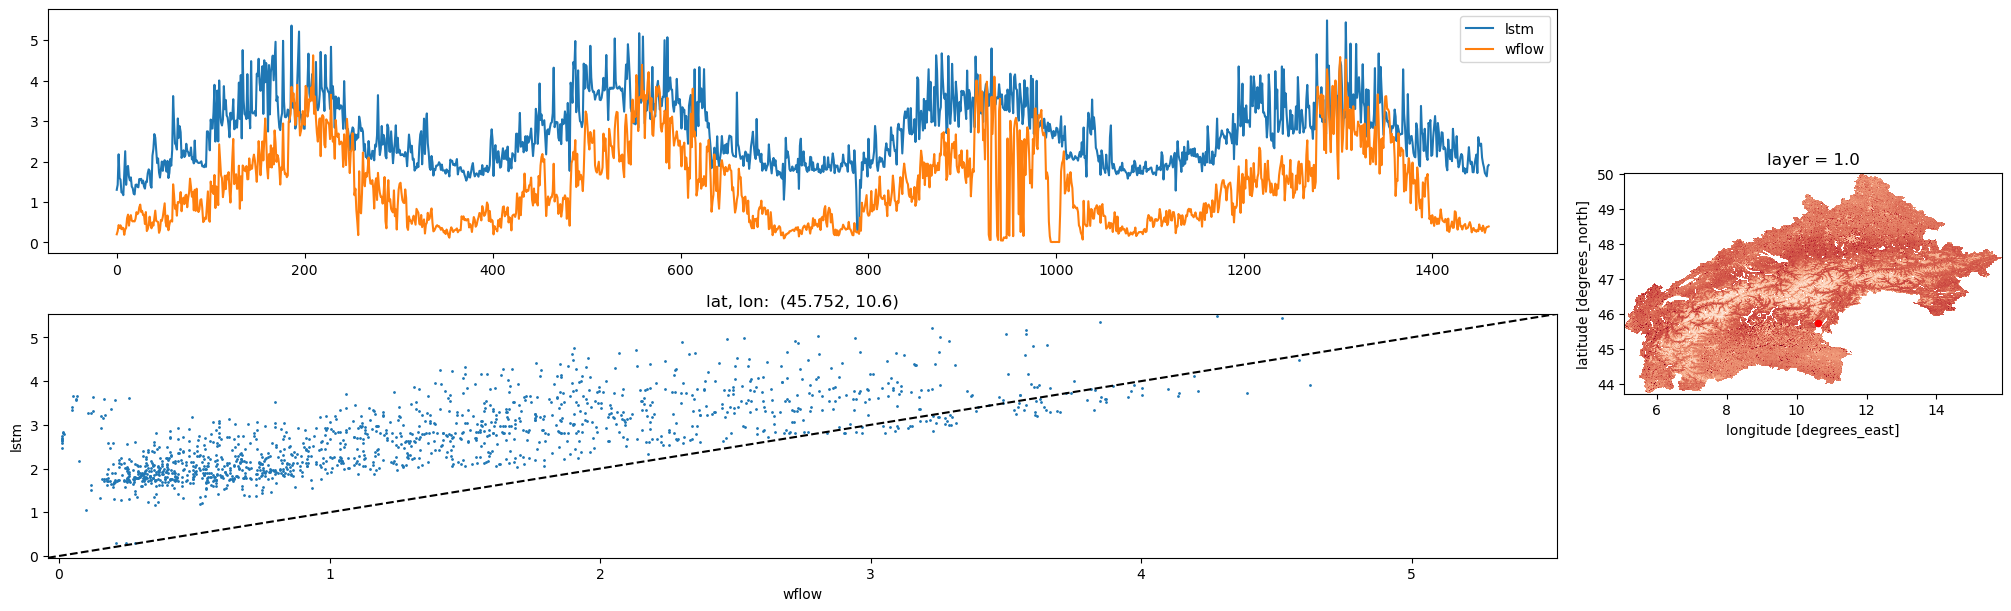

In [33]:
ts_compare(y, yhat, lat = [45.752], lon = [10.6]) 

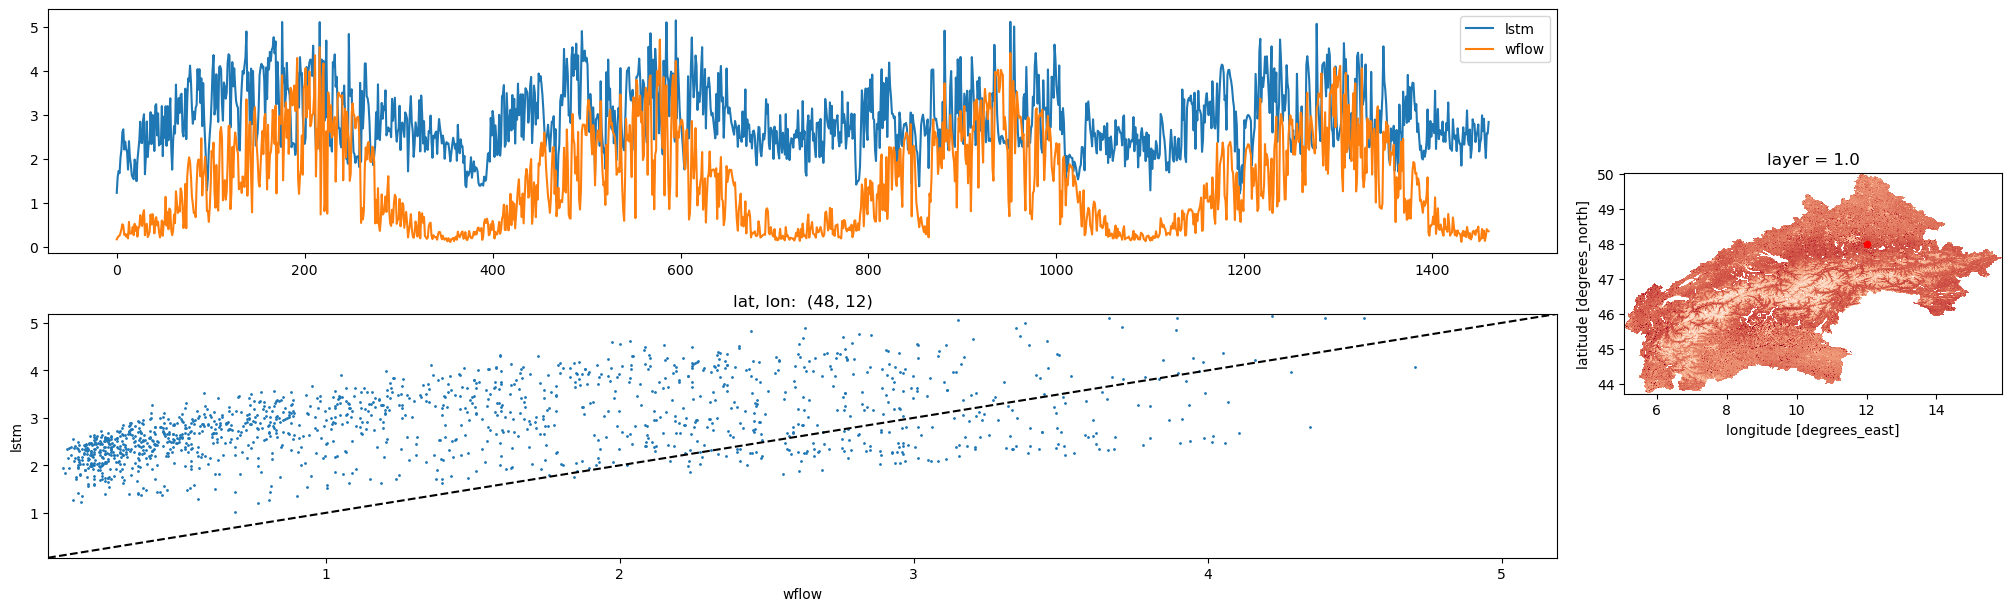

In [34]:
ts_compare(y, yhat, lat = [48], lon = [12]) 

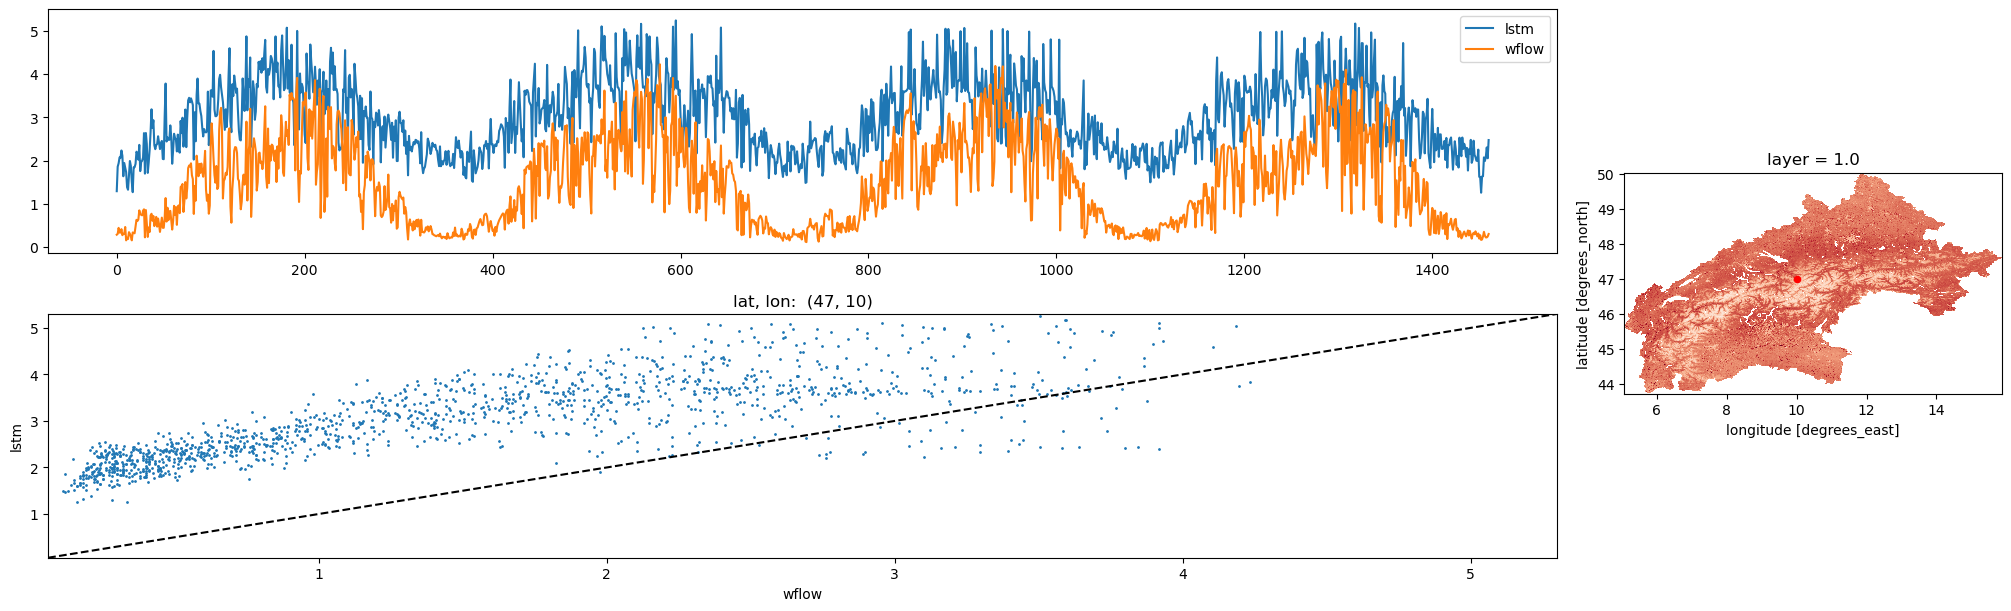

In [36]:
ts_compare(y, yhat, lat = [47], lon = [10]) 

In [ ]:
map_at_timesteps(y, yhat, dates=["2019-01-01", "2019-06-01","2019-10-01"])